# Neural Networks as statistical models (Mixture Density Networks)

## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

We’ll estimate conditional densities \(p(y\mid x)\) with three progressively richer models:
1. **Deterministic regression** trained by MSE (predict a point estimate).
2. **Gaussian regression** that outputs a Normal distribution \( \mathcal N(\mu(x),\sigma(x)^2) \) and is trained by **negative log-likelihood (NLL)**.
3. **Mixture Density Network (MDN)** that outputs a Gaussian mixture to capture **multi-modality/heteroscedasticity**.

Along the way we’ll:
- Compare **MSE vs. NLL** objectives.
- Visualize **predictive mean/uncertainty**.
- Plot the learned **conditional density** \(p(y\mid x)\).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

device: cpu


## 1) Toy data: non-linear, heteroscedastic

We design \( y\mid x \) to be **multimodal** for some \(x\) (two possible branches) and with **changing noise**.

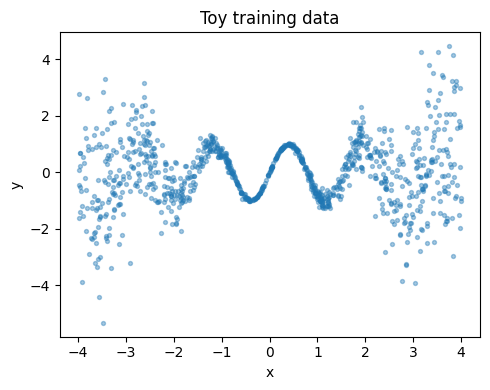

In [46]:
# Generate training data
N = 2000
x = np.random.uniform(-4.0, 4.0, size=(N,1)).astype(np.float32)


rng = np.random.default_rng(0)
# noise incereases with x square
y= np.sin(4*x) + 0.15 * x*x*rng.standard_normal(size=x.shape).astype(np.float32)


x_t = torch.tensor(x, device=device)
y_t = torch.tensor(y, device=device)

# Train/test grids
x_grid = np.linspace(-4,4,400, dtype=np.float32).reshape(-1,1)
xg_t = torch.tensor(x_grid, device=device)

plt.figure(figsize=(5,4))
plt.scatter(x[:1000,0], y[:1000,0], s=8, alpha=0.4)
plt.title("Toy training data"); plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()

## 2) Common helpers

In [57]:
def batches(X, Y, bs=256):
    N = X.shape[0]
    idx = torch.randperm(N, device=X.device)
    for i in range(0, N, bs):
        j = idx[i:i+bs]
        yield X[j], Y[j]

@torch.no_grad()
def plot_regression(x, y, x_grid, mean, std=None, title=""):
    plt.figure(figsize=(6,4))
    plt.scatter(x[:1500,0].cpu(), y[:1500,0].cpu(), s=8, alpha=0.35, label="data")
    plt.plot(x_grid[:,0].cpu(), mean.cpu(), lw=2, label="mean",color='red')
    if std is not None:
        m = mean.cpu().numpy().reshape(-1)
        s = std.cpu().numpy().reshape(-1)
        up = m + 2*s; lo = m - 2*s
        plt.fill_between(x_grid[:,0].cpu(), lo, up, alpha=0.25, label="±2σ")
    plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

@torch.no_grad()
def plot_density(x_grid, y_lims=(-3.5,3.5), steps=200, logp_fn=None, title="p(y|x)",logplot=None):
    y_lin = torch.linspace(y_lims[0], y_lims[1], steps, device=x_grid.device).view(1,-1)
    X = x_grid  # [G,1]
    Y = y_lin.repeat(X.size(0),1)  # [G,S]
    # Evaluate log p(y|x) for each grid pair
    lp = logp_fn(X, Y)  # should return [G,S]
    
    p = lp.exp().cpu().numpy()
    if logplot is not None:
        p=lp.cpu().numpy()
    Xg, Yg = np.meshgrid(X[:,0].cpu().numpy(), y_lin[0].cpu().numpy())
    plt.figure(figsize=(6,4))
    plt.contourf(Xg, Yg, p.T, levels=100)
    plt.colorbar(label="p(y|x)")
    plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()

## 3) Deterministic regression (MSE)

A basic MLP predicts a single \( \hat y(x) \). This optimizes the **mean-squared error** and **cannot** represent multi-modality or heteroscedasticity.

[MSE] epoch 200 loss=1.1636
[MSE] epoch 400 loss=1.0380
[MSE] epoch 600 loss=1.0863
[MSE] epoch 800 loss=1.0529


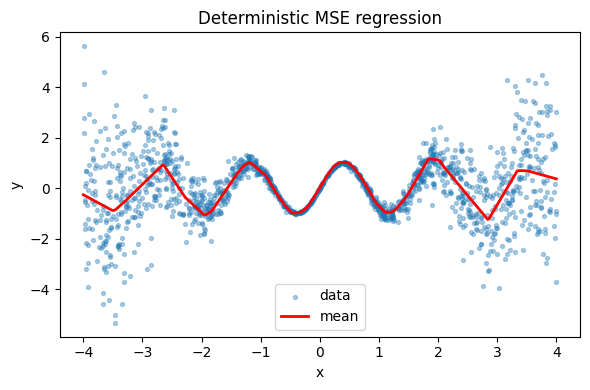

In [50]:
class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, out_dim),
        )
    def forward(self, x):
        return self.net(x)

mse_model = MLP().to(device)
opt = optim.Adam(mse_model.parameters(), lr=1e-3)

for ep in range(800):
    for xb, yb in batches(x_t, y_t, bs=256):
        pred = mse_model(xb)
        loss = F.mse_loss(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if (ep+1) % 200 == 0:
        print(f"[MSE] epoch {ep+1} loss={loss.item():.4f}")

with torch.no_grad():
    mean = mse_model(xg_t).squeeze(-1)
plot_regression(x_t, y_t, xg_t, mean, None, title="Deterministic MSE regression")

## 4) Gaussian regression (NLL)

Network outputs **mean** and **log-std**; we train by **negative log-likelihood**:
\[
\mathcal{L} = -\frac{1}{B}\sum_{i=1}^B \log \mathcal N\big(y_i;\ \mu(x_i), \sigma(x_i)^2\big).
\]
This captures **heteroscedastic** noise but remains **unimodal**.

[Gaussian] epoch 200 nll=0.3593
[Gaussian] epoch 400 nll=0.4237
[Gaussian] epoch 600 nll=0.3813
[Gaussian] epoch 800 nll=0.5786


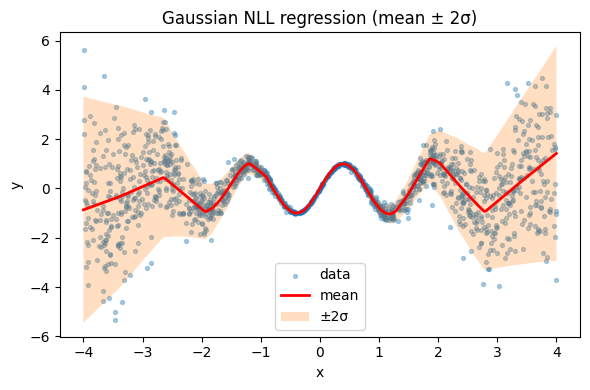

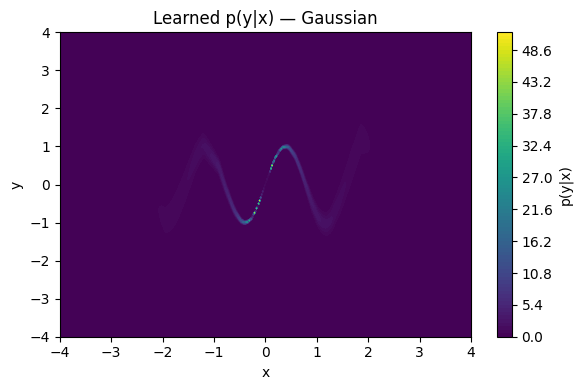

In [60]:
class GaussianReg(nn.Module):
    def __init__(self, in_dim=1, width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, 2)  # output [mu, log_std]
        )
    def forward(self, x):
        h = self.net(x)
        mu = h[..., :1]
        log_std = h[..., 1:]
        std = F.softplus(log_std) + 1e-4  # keep positive and stable
        return mu, std

def gaussian_nll(mu, std, y):
    dist = D.Normal(loc=mu.squeeze(-1), scale=std.squeeze(-1))
    return -dist.log_prob(y.squeeze(-1)).mean()

g_model = GaussianReg().to(device)
opt = optim.Adam(g_model.parameters(), lr=1e-3)

for ep in range(800):
    for xb, yb in batches(x_t, y_t, bs=256):
        mu, std = g_model(xb)
        loss = gaussian_nll(mu, std, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if (ep+1) % 200 == 0:
        print(f"[Gaussian] epoch {ep+1} nll={loss.item():.4f}")

with torch.no_grad():
    mu, std = g_model(xg_t)
plot_regression(x_t, y_t, xg_t, mu.squeeze(-1), std.squeeze(-1), title="Gaussian NLL regression (mean ± 2σ)")

@torch.no_grad()
def logp_gaussian(X, Y):
    mu, std = g_model(X)  # [G,1], [G,1]
    dist = D.Normal(mu, std)
    return dist.log_prob(Y)

plot_density(xg_t, y_lims=(-4,4), steps=200, logp_fn=logp_gaussian,title="Learned p(y|x) — Gaussian")

## 5) Mixture Density Network (Gaussian Mixture)

The network outputs parameters of a \(K\)-component Gaussian mixture:
- logits \(\pi_k(x)\),
- means \(\mu_k(x)\),
- scales \(\sigma_k(x)\).

We still train by **negative log-likelihood** (log-sum-exp under the hood), which lets us fit **multi-modal** \(p(y\mid x)\).

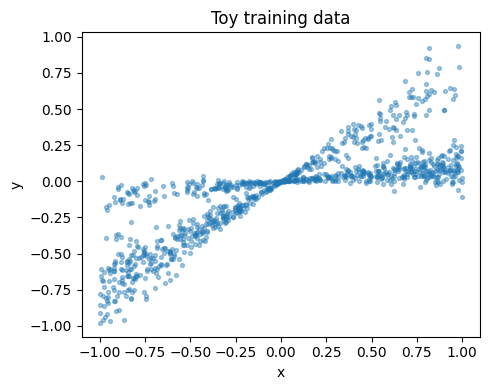

In [71]:
# Generate training data
N = 2000
x = np.random.uniform(-1.0, 1.0, size=(N,1)).astype(np.float32)

# Conditional: two linear branches with different noise levels 
def sample_y(xv,rng):
    # Mix probability depends on x
    w = 1/(1 + np.exp(-1.5*xv))  # smoothly increases with x
    # Branch 1: linear with noise
    y1=0.1 * xv + np.random.normal(0, 0.025, size=(N,1)) * 3 * xv
    # Branch 2: linear with larger noise
    y2 =  0.75 * xv + np.random.normal(0, 0.025, size=(N,1)) * 6 * xv
    choose = rng.uniform(size=xv.shape) < w
    return np.where(choose, y1, y2)

rng = np.random.default_rng(0)
y = sample_y(x,rng).astype(np.float32)

xbig_t = torch.tensor(x, device=device)
ybig_t = torch.tensor(y, device=device)

# Train/test grids
x_grid = np.linspace(-1,1,400, dtype=np.float32).reshape(-1,1)
xg_t = torch.tensor(x_grid, device=device)

plt.figure(figsize=(5,4))
plt.scatter(x[:1000,0], y[:1000,0], s=8, alpha=0.4)
plt.title("Toy training data"); plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()


[Gaussian] epoch 200 nll=-0.7663
[Gaussian] epoch 400 nll=-0.6682
[Gaussian] epoch 600 nll=-0.7905
[Gaussian] epoch 800 nll=-0.6392


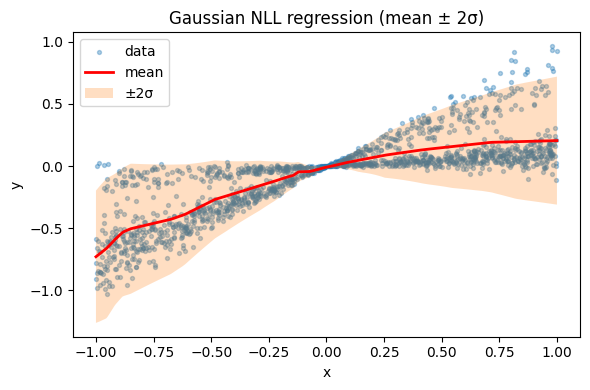

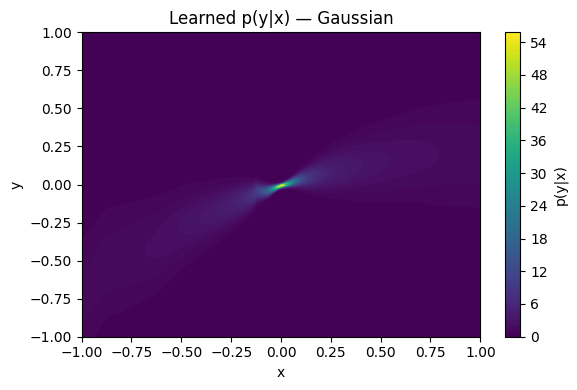

In [72]:
class GaussianReg(nn.Module):
    def __init__(self, in_dim=1, width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, 2)  # output [mu, log_std]
        )
    def forward(self, x):
        h = self.net(x)
        mu = h[..., :1]
        log_std = h[..., 1:]
        std = F.softplus(log_std) + 1e-4  # keep positive and stable
        return mu, std

def gaussian_nll(mu, std, y):
    dist = D.Normal(loc=mu.squeeze(-1), scale=std.squeeze(-1))
    return -dist.log_prob(y.squeeze(-1)).mean()

g_model = GaussianReg().to(device)
opt = optim.Adam(g_model.parameters(), lr=1e-3)

for ep in range(800):
    for xb, yb in batches(xbig_t, ybig_t, bs=256):
        mu, std = g_model(xb)
        loss = gaussian_nll(mu, std, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if (ep+1) % 200 == 0:
        print(f"[Gaussian] epoch {ep+1} nll={loss.item():.4f}")

with torch.no_grad():
    mu, std = g_model(xg_t)
plot_regression(xbig_t, ybig_t, xg_t, mu.squeeze(-1), std.squeeze(-1), title="Gaussian NLL regression (mean ± 2σ)")

@torch.no_grad()
def logp_gaussian(X, Y):
    mu, std = g_model(X)  # [G,1], [G,1]
    dist = D.Normal(mu, std)
    return dist.log_prob(Y)

plot_density(xg_t, y_lims=(-1,1), steps=200, logp_fn=logp_gaussian, title="Learned p(y|x) — Gaussian")

[MDN] epoch 300 nll=-1.1264
[MDN] epoch 600 nll=-1.2416
[MDN] epoch 900 nll=-1.3284
[MDN] epoch 1200 nll=-1.2653


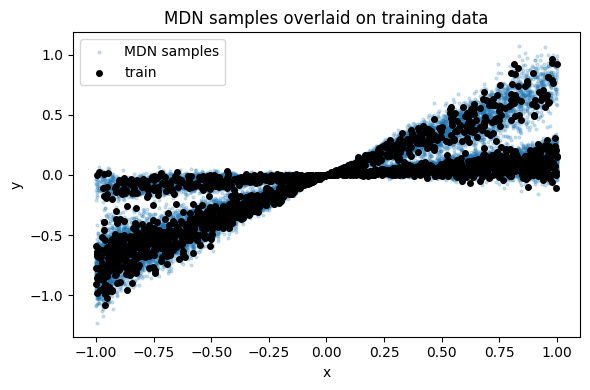

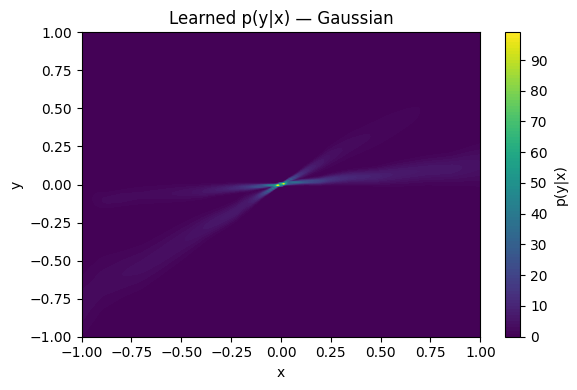

In [74]:
class MDN(nn.Module):
    def __init__(self, in_dim=1, K=3, width=200):
        super().__init__()
        self.K = K
        self.shared = nn.Sequential(
            nn.Linear(in_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
        )
        self.logits = nn.Linear(width, K)
        self.means  = nn.Linear(width, K)
        self.scales = nn.Linear(width, K)  # we'll softplus
    def forward(self, x):
        h = self.shared(x)
        logits = self.logits(h)
        means = self.means(h)
        scales = F.softplus(self.scales(h)) + 1e-4
        return logits, means, scales

def mdn_nll(logits, means, scales, y):
    # y: [B,1]; params: [B,K]
    comp = D.Normal(loc=means, scale=scales)                # [B,K]
    log_probs = comp.log_prob(y)                            # [B,K]
    log_mix = torch.log_softmax(logits, dim=-1) + log_probs # [B,K]
    log_px = torch.logsumexp(log_mix, dim=-1)               # [B,1]
    return -log_px.mean()

mdn = MDN(K=2).to(device)
opt = optim.Adam(mdn.parameters(), lr=1e-3)

for ep in range(1200):
    for xb, yb in batches(xbig_t, ybig_t, bs=256):
        logits, means, scales = mdn(xb)
        loss = mdn_nll(logits, means, scales, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if (ep+1) % 300 == 0:
        print(f"[MDN] epoch {ep+1} nll={loss.item():.4f}")

@torch.no_grad()
def logp_mdn(X, Y):
    # X: [G,1], Y: [G,S]
    logits, means, scales = mdn(X)                  # [G,K] each
    comp = D.Normal(means.unsqueeze(-1),            # [G,K,1]
                    scales.unsqueeze(-1))           # [G,K,1]
    log_probs = comp.log_prob(Y.unsqueeze(1))       # [G,K,S]
    log_mix   = torch.log_softmax(logits, -1).unsqueeze(-1) + log_probs  # [G,K,S]
    return torch.logsumexp(log_mix, dim=1)          # [G,S]


@torch.no_grad()
def sample_from_mdn(mdn, x_points, n_per_x=10, device=None, jitter_x=0.0):
    """
    Returns flattened arrays (xs, ys) of MDN samples evaluated at the given x_points.
    x_points: array-like of shape [G] or [G,1]
    n_per_x:  number of samples to draw per x
    jitter_x: small horizontal jitter (std) to reduce visual banding
    """
    if device is None:
        device = next(mdn.parameters()).device
    X = torch.as_tensor(x_points, dtype=torch.float32, device=device).view(-1, 1)  # [G,1]
    logits, means, scales = mdn(X)                     # [G,K] each
    mix = D.Categorical(logits=logits)                 # batch [G]
    k = mix.sample((n_per_x,))                         # [S,G]

    # Gather component params per sample
    means_exp  = means.unsqueeze(0).expand(n_per_x, -1, -1)   # [S,G,K]
    scales_exp = scales.unsqueeze(0).expand(n_per_x, -1, -1)  # [S,G,K]
    idx = k.unsqueeze(-1)                                     # [S,G,1]
    sel_means  = means_exp.gather(2, idx).squeeze(-1)         # [S,G]
    sel_scales = scales_exp.gather(2, idx).squeeze(-1)        # [S,G]

    eps = torch.randn_like(sel_means)
    y_samp = sel_means + sel_scales * eps                     # [S,G]
    x_rep  = X.squeeze(-1).unsqueeze(0).expand_as(y_samp)     # [S,G]

    xs = x_rep.cpu().numpy().reshape(-1)
    ys = y_samp.cpu().numpy().reshape(-1)
    if jitter_x > 0:
        xs = xs + np.random.normal(0.0, jitter_x, size=xs.shape)
    return xs, ys

# choose x locations (grid or your training x’s)
x_grid = np.linspace(-1, 1, 400, dtype=np.float32)
xs, ys = sample_from_mdn(mdn, x_grid, n_per_x=80, jitter_x=0.000)

plt.figure(figsize=(6,4))

plt.scatter(xs, ys, s=4, alpha=0.2, label="MDN samples")
plt.scatter(x.reshape(-1), y.reshape(-1), s=16, alpha=1, c="k", label="train")
plt.xlabel("x"); plt.ylabel("y"); plt.title("MDN samples overlaid on training data")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()



plot_density(xg_t, y_lims=(-1,1), steps=200, logp_fn=logp_mdn, title="Learned p(y|x) — Gaussian")

## 6) Draw samples from the predictive distributions

We visualize **samples** from the learned \(p(y\mid x)\) at a few \(x\) locations to highlight multi-modality.

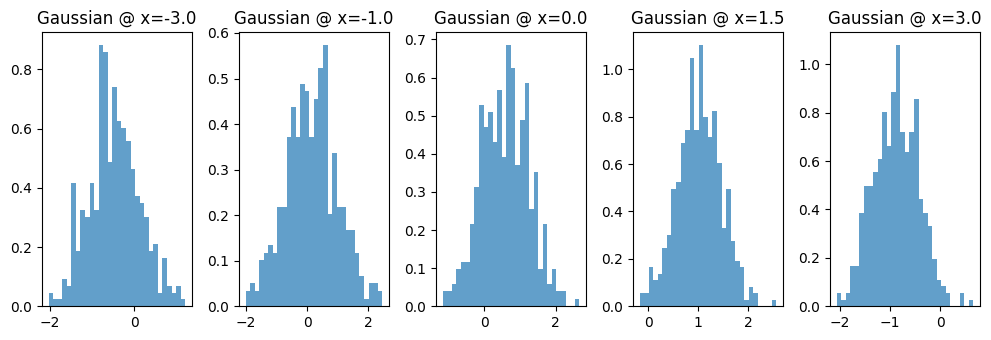

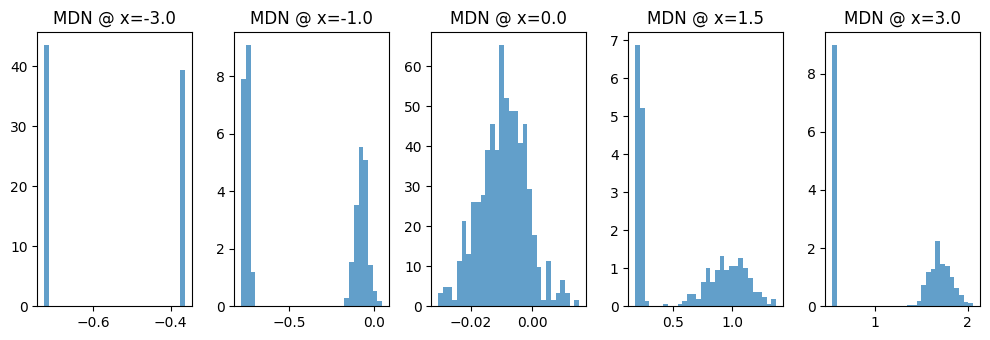

In [20]:
@torch.no_grad()
def sample_gaussian(x_points, n_samples=200):
    X = torch.tensor(x_points, dtype=torch.float32, device=device).view(-1,1)
    mu, std = g_model(X)
    dist = D.Normal(mu, std)
    return dist.sample((n_samples,)).cpu().numpy().squeeze(-1)  # [S,G]

@torch.no_grad()
def sample_mdn(x_points, n_samples=200):
    X = torch.tensor(x_points, dtype=torch.float32, device=device).view(-1,1)
    logits, means, scales = mdn(X)          # [G,K]
    mix = D.Categorical(logits=logits)      # [G]
    k = mix.sample((n_samples,))            # [S,G]
    comp = D.Normal(means, scales)          # [G,K]
    # Gather selected component parameters for each sample
    idx = k.unsqueeze(-1)                   # [S,G,1]
    sel_means  = torch.gather(means.unsqueeze(0).expand(n_samples,-1,-1), 2, idx).squeeze(-1)   # [S,G]
    sel_scales = torch.gather(scales.unsqueeze(0).expand(n_samples,-1,-1), 2, idx).squeeze(-1) # [S,G]
    eps = torch.randn_like(sel_means)
    samp = sel_means + sel_scales * eps
    return samp.cpu().numpy()  # [S,G]

xs = np.array([-3.0, -1.0, 0.0, 1.5, 3.0], dtype=np.float32)

s_gauss = sample_gaussian(xs, n_samples=400)
s_mdn   = sample_mdn(xs, n_samples=400)

plt.figure(figsize=(10,3.5))
for i, xv in enumerate(xs):
    plt.subplot(1,len(xs),i+1)
    plt.hist(s_gauss[:,i].reshape(-1), bins=30, density=True, alpha=0.7)
    plt.title(f"Gaussian @ x={xv:.1f}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
for i, xv in enumerate(xs):
    plt.subplot(1,len(xs),i+1)
    plt.hist(s_mdn[:,i].reshape(-1), bins=30, density=True, alpha=0.7)
    plt.title(f"MDN @ x={xv:.1f}")
plt.tight_layout(); plt.show()

## 7) Summary
- **MSE** learns a point estimate and blurs multi-modal targets.
- **Gaussian NLL** learns mean **and** uncertainty, modeling heteroscedasticity but still one mode.
- **MDN (mixture NLL)** captures **multi-modality** and sharp conditional densities.

All training used **maximum likelihood** (minimizing negative log-probability).